In [1]:
import torch

import hiddenlayer as h1
for model in ["he","hu","luo_cnn","santara","cao"]:
    # one onnx for each of ["he", "hu", "luo_cnn", "santara", "cao"]
    model_object = None
    input_var = None
    if model == "he":
        from DeepHyperX.models import HeEtAl

        model_object = HeEtAl(200, 17, 7)
        # input_var = torch.FloatTensor(torch.randn((2, 1, 200, 7, 7), requires_grad=True))
        # input_var = torch.FloatTensor(torch.randn((100, 1, 200, 7, 7), requires_grad=True))
    elif model == "hu":
        from DeepHyperX.models import HuEtAl

        model_object = HuEtAl(200, 17)
        # input_var = torch.FloatTensor(torch.randn((2, 200), requires_grad=True))
    elif model == "luo_cnn":
        from DeepHyperX.models import LuoEtAl

        model_object = LuoEtAl(200, 17, patch_size=3)
        # input_var = torch.FloatTensor(torch.randn((2, 1, 200, 3, 3), requires_grad=True))
    elif model == "santara":
        from DeepHyperX.custom_models import Santara16

        model_object = Santara16(n_channels=200, block1_conv1=3330, n_bands=10, patch_size=3, n_classes=17)
        # input_var = torch.FloatTensor(torch.randn((2, 1, 200, 3, 3), requires_grad=True))
        # input_var = torch.FloatTensor(torch.randn((100, 1, 200, 3, 3), requires_grad=True))
    elif model == "cao":
        from DeepHyperX.custom_models import Cao17

        model_object = Cao17(patch_size=9, num_band=200, num_classes=17)
        # input_var = torch.FloatTensor(torch.randn((2, 1, 200, 9, 9), requires_grad=True)) # 100
    input_var = torch.FloatTensor(torch.randn(tuple(expected_input_shapes[model]), requires_grad=True))

    h1_graph = h1.build_graph(model_object, torch.zeros(expected_input_shapes[model]))
    h1_graph.theme = h1.graph.THEMES["blue"].copy()
    # model_object.load_state_dict(torch.load(model_path))
    # model_object.train(False)

ImportError: No module named 'hiddenlayer'

In [2]:
import os
import scipy.io

# main work path
os.chdir(r'D:\Yue\Process\hsi_lstm\experiment')
import SSM

# map_name = 'Pavia'
map_name = 'Indian'
smat = 'predict_map_Indian_stssgru'

# augmentation
AUG = 1

AT = 0         # Attention model
ST = 1         # Shorten
SS = 1         # Spatial-spectral RNN
RU = 'GRU'     # RNN Unit: GRU/LSTM

# hyperparameter
hidden_size = 128
n_time = 5
n_filter = 16
m_filter = 16
n_em = 4

max_lr = 0.005
min_lr = 0.000001
decay_speed = 2000.0
_batch_size = 512
n_iter = 3000
n_exp_times = 1

In [3]:
# setting: dataset
if map_name == 'Pavia':
    img_file = 'PaviaU'
    img_id = 'paviaU'
    gt_file = 'PaviaU_gt'
    gt_id = 'paviaU_gt'
    trainN = [548, 540, 392, 542, 256, 532, 375, 514, 231]
    class_num = 9
    Ashape = [610, 340, 103]
elif map_name == 'Indian':
    img_file = 'Indian_pines_corrected'
    img_id = 'indian_pines_corrected'
    gt_file = 'Indian_pines_gt'
    gt_id = 'indian_pines_gt'
    trainN = [30, 150, 150, 100, 150, 150, 20, 150, 15, 150, 150, 150, 150, 150, 50, 50]
    # trainN = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 15, 15, 15]
    class_num = 16
    Ashape = [145, 145, 200]
r_win = 1
if SS == 1:
    r_win = 5
timestep_size = Ashape[-1]


In [4]:
# setting: GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
print(datetime.datetime.now())

2018-06-23 00:26:07.922239


In [5]:
n_same = timestep_size % n_time
n_f = timestep_size // n_time + n_same
n_same = n_f - n_same

n_em -= 1

batch_size = tf.placeholder(tf.int32,[])

X_input = tf.placeholder(tf.float32, [None, r_win, r_win, timestep_size])
Y = tf.placeholder(tf.float32, [None, class_num])
lr = tf.placeholder(tf.float32)

if SS == 0:
    X = tf.reshape(X_input, [-1, timestep_size, 1])
    m_filter = 1
    X_mask = tf.reshape(X_input, [-1, timestep_size])
elif SS == 1:
    X = tf.transpose(tf.reshape(X_input, [-1, 1, r_win, r_win, timestep_size]), [0, 4, 2, 3, 1])
    sfilter_3d1 = tf.Variable(tf.random_normal([1, 5, 5, 1, n_filter]))
    sfilter_3d2 = tf.Variable(tf.random_normal([1, 3, 3, 1, n_filter]))
    sfilter_3d3 = tf.Variable(tf.random_normal([1, 1, 1, 1, n_filter]))
    X_spatial1 = tf.nn.relu(tf.nn.conv3d(X, sfilter_3d1, strides=[1, 1, 1, 1, 1], padding='VALID'))
    X_spatial2 = tf.nn.max_pool3d(tf.nn.relu(tf.nn.conv3d(X, sfilter_3d2, strides=[1, 1, 1, 1, 1], padding='VALID')),[1,1,3,3,1],[1,1,1,1,1],padding='VALID')
    X_spatial3 = tf.nn.max_pool3d(tf.nn.relu(tf.nn.conv3d(X, sfilter_3d3, strides=[1, 1, 1, 1, 1], padding='VALID')),[1,1,5,5,1],[1,1,1,1,1],padding='VALID')
    X = X_spatial1 + X_spatial2 + X_spatial3
    X = tf.reshape(X, [-1, X.get_shape()[1], n_filter])
    mid = r_win // 2
    X_mask = tf.reshape(X_input[:, mid, mid, :], [-1, timestep_size])

if AT == 1:
    # attention model
    W = tf.Variable(tf.zeros([timestep_size, timestep_size]), dtype=tf.float32)
    bias = tf.Variable(tf.ones([timestep_size]), dtype=tf.float32)
    X_mask = tf.nn.sigmoid(tf.matmul(X_mask, W) + bias)
    X_mask = tf.reshape(X_mask, [-1, timestep_size])
    X = tf.reshape(X * X_mask, [-1, timestep_size, 1])    

if ST == 1:
    sfilter_1d = tf.Variable(tf.random_normal([n_f, m_filter, hidden_size]))
    X = tf.nn.relu(tf.nn.conv1d(X, sfilter_1d, n_same,padding='VALID'))

if RU == 'LSTM':
    ru_cell = rnn.LSTMCell(hidden_size)
elif RU == 'GRU':
    ru_cell = rnn.GRUCell(hidden_size)

init_state = ru_cell.zero_state(batch_size, dtype=tf.float32)
outputs, state = tf.nn.dynamic_rnn(ru_cell, inputs=X, initial_state=init_state, time_major=False)
Hsum = outputs[:, -1, :]
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1, shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(Hsum, W) + bias)

print(outputs.shape)
print(y_pre.get_shape())

if n_em > 0:
    for em in range(n_em):
        if RU == 'LSTM':
            ru_cell = rnn.LSTMCell(hidden_size, name='%s' % em)
        elif RU == 'GRU':
            ru_cell = rnn.GRUCell(hidden_size, name='%s' % em)
        init_state = ru_cell.zero_state(batch_size, dtype=tf.float32)
        outputs, state = tf.nn.dynamic_rnn(ru_cell, inputs=X, initial_state=init_state, time_major=False)
        Hsum = outputs[:, -1, :]
        W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
        bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
        y_pre += tf.nn.softmax(tf.matmul(Hsum, W) + bias)

# Loss Function
cross_entropy = -tf.reduce_mean(Y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
Y_hat = tf.argmax(y_pre, 1)
correct_prediction = tf.equal(Y_hat, tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

(?, 5, 128)
(?, 16)


In [6]:
result = []

for _ntime in range(n_exp_times):
    _t = []
    samples = SSM.SSM(Ashape, r_win, class_num, AUG, _ntime + 1)
    samples.load(img_file, img_id, gt_file, gt_id, 0, 1)
    samples.normalization(0)
    samples.init_sam2(trainN, [0])
    samples.load_all_sam()
    sess.run(tf.global_variables_initializer())
    st = datetime.datetime.now()
    ss = time.time()
    for i in range(n_iter):
        sambatch, labbatch, _ = samples.loop_sample(i, _batch_size)
        learning_rate = min_lr + (max_lr - min_lr) * math.exp(-i/decay_speed)
        if (i + 1) % 200 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={
                X_input:sambatch, Y: labbatch, batch_size: _batch_size, lr:learning_rate})
        sess.run(train_op, feed_dict={X_input: sambatch, Y: labbatch, batch_size: _batch_size, lr:learning_rate})
    print("Runtime:%s, Iter%d, step %d, training accuracy %g" % (datetime.datetime.now() - st, (i+1)/200,
                                                             (i+1), train_accuracy))
    print(time.time() - ss) 
    _t.append(time.time() - ss)
    # Acc
    if map_name == 'Indian':
        x1 = 1500 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][:1500],
            Y: samples.test['label_v'][:1500],
            batch_size:1500})
        x2 = 1500 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][1500:3000],
            Y: samples.test['label_v'][1500:3000],
            batch_size:1500})
        x3 = 1500 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][3000:4500],
            Y: samples.test['label_v'][3000:4500],
            batch_size:1500})
        x4 = 1500 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][4500:6000],
            Y: samples.test['label_v'][4500:6000],
            batch_size:1500})
        x5 = 1500 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][6000:7500],
            Y: samples.test['label_v'][6000:7500],
            batch_size:1500})
        x6 = 984 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][7500:8484],
            Y: samples.test['label_v'][7500:8484],
            batch_size:984})
        xx = (x1+x2+x3+x4+x5+x6)/8484
    elif map_name == 'Pavia':
        xx = 2846 * sess.run(accuracy, feed_dict={
            X_input: samples.test['sample'][36000:38846],
            Y: samples.test['label_v'][36000:38846],
            batch_size:2846})
        for i in range(12):
            time.sleep(1)
            xx += 3000 * sess.run(accuracy, feed_dict={
                X_input: samples.test['sample'][i*3000:(i+1)*3000],
                Y: samples.test['label_v'][i*3000:(i+1)*3000],
                batch_size:3000})
        xx /= 38484
    print(xx)
    _t.append(xx)
    result.append(_t)

Runtime:0:05:33.551632, Iter15, step 3000, training accuracy 0.847656
333.551632642746
0.6229372935888622


In [7]:
result = np.array(result)
print(np.mean(result,axis=0))
print(np.std(result,axis=0))

[333.55163264   0.62293729]
[0. 0.]


In [8]:
pm = [] 
if map_name == 'Pavia':
    for i in range(70):
        time.sleep(0.5)
        pm.append(sess.run(Y_hat, feed_dict={X_input: samples.all['sample'][i*3000:i*3000+3000],batch_size:len(samples.all['sample'][i*3000:i*3000+3000])}))
    pm=np.reshape(np.concatenate(pm),[610,340])
elif map_name == 'Indian':
    for i in range(15):
        time.sleep(1)
        pm.append(sess.run(Y_hat, feed_dict={X_input: samples.all['sample'][i*1500:i*1500+1500],batch_size:len(samples.all['sample'][i*1500:i*1500+1500])}))
    pm=np.reshape(np.concatenate(pm),[145,145])

In [9]:
import scipy
scipy.io.savemat(smat, {'pm':pm})

In [10]:
import matplotlib.pyplot as plt
plt.imshow(pm)
plt.axis('off')
plt.show()

<Figure size 640x480 with 1 Axes>

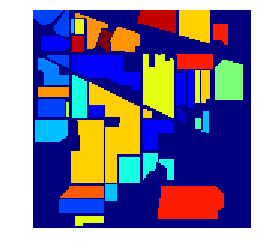

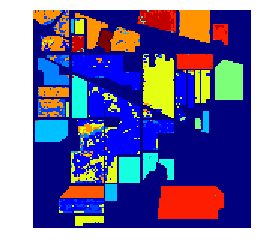

In [11]:
plt.imshow(samples.img['gt']+1,cmap=plt.cm.jet)
plt.axis('off')
plt.show()
plt.imshow((pm+1)*(samples.img['gt']!=255),cmap=plt.cm.jet)
plt.axis('off')
plt.show()